# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import kendalltau
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Data Load

In [2]:
transport_data = pd.read_csv('TravelMileage.csv')
transport_data.set_index('Date', inplace=True)

# Data Cleansing

#### Handle missing values

In [3]:
missing_values = transport_data.isnull().sum()
transport_data = transport_data.fillna(method='ffill').fillna(method='bfill')
print(f"Missing values before handling:\n{missing_values}")

Missing values before handling:
Average Mileage (km)      0
Trip Distance (km)        0
Average Fuel Level (%)    0
Average Speed (km/h)      0
Total Engine Hours (h)    0
Maintenance Amount        0
dtype: int64


#### Handle duplicate values

In [4]:
duplicates = transport_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
transport_data = transport_data.drop_duplicates()

Number of duplicate rows: 0


#### Handle Outliers

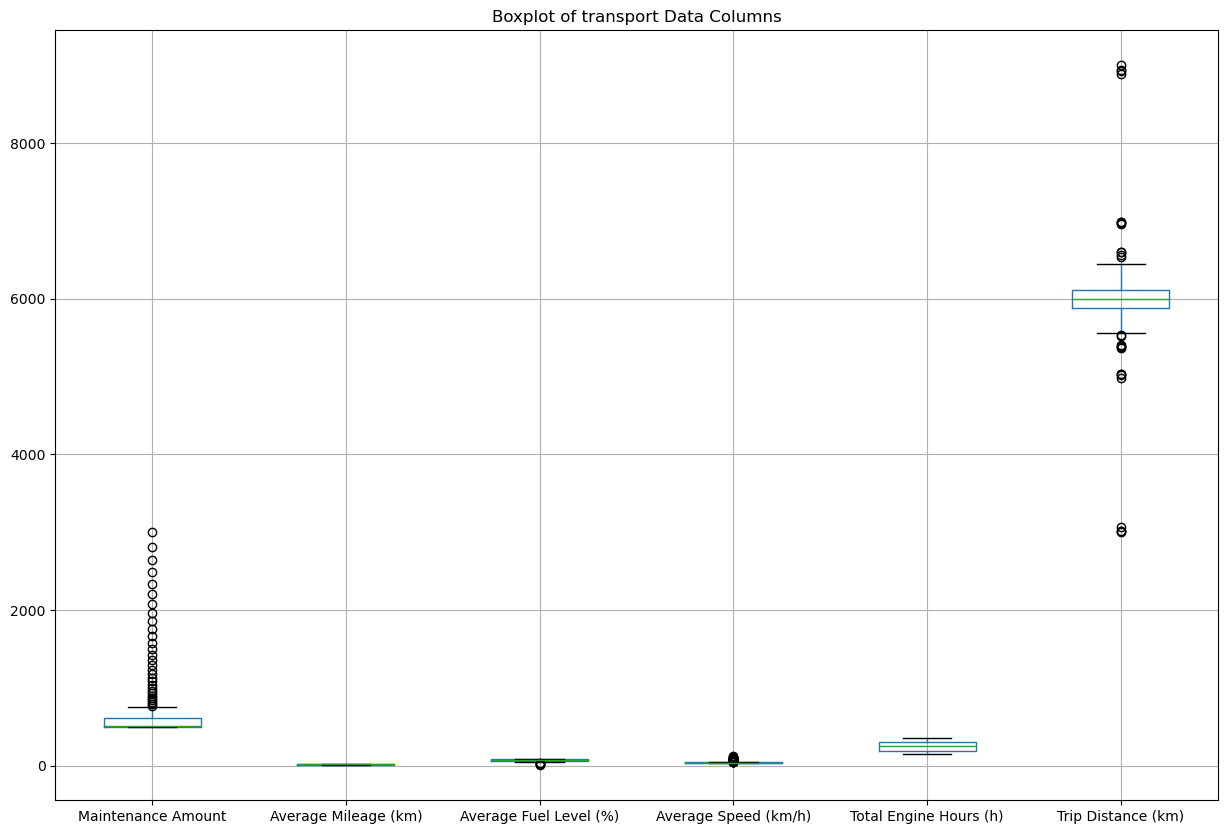

In [5]:
plt.figure(figsize=(15, 10))
transport_data.boxplot(column=['Maintenance Amount', 'Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 
                               'Total Engine Hours (h)', 'Trip Distance (km)'])
plt.title('Boxplot of transport Data Columns')
plt.show()

In [6]:
z_scores = np.abs(stats.zscore(transport_data))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")
transport_data = transport_data[~outliers]

Number of outliers detected: 18


#### Correct Data types

In [7]:
transport_data = transport_data.astype({
    'Maintenance Amount': 'float64',
    'Average Mileage (km)': 'float64',
    'Average Fuel Level (%)': 'float64',
    'Average Speed (km/h)': 'float64',
    'Total Engine Hours (h)': 'float64',
    'Trip Distance (km)': 'float64'
})

#### Normalize data

In [8]:
scaler = StandardScaler()
transport_data_scaled = pd.DataFrame(scaler.fit_transform(transport_data), columns=transport_data.columns, index=transport_data.index)

#### Check for Inconsistencies

In [9]:
inconsistent_values = (transport_data['Average Mileage (km)'] > transport_data['Average Speed (km/h)']).sum()
print(f"Number of inconsistencies in Average Mileage (km) and Average Speed (km/h)s: {inconsistent_values}")

transport_data['Average Mileage (km)'], transport_data['Average Speed (km/h)'] = np.where(transport_data['Average Mileage (km)'] > transport_data['Average Speed (km/h)'],
                                                        [transport_data['Average Speed (km/h)'], transport_data['Average Mileage (km)']],
                                                        [transport_data['Average Mileage (km)'], transport_data['Average Speed (km/h)']])
transport_data.head()

Number of inconsistencies in Average Mileage (km) and Average Speed (km/h)s: 0


,Average Mileage (km),Trip Distance (km),Average Fuel Level (%),Average Speed (km/h),Total Engine Hours (h),Maintenance Amount
Date,,,,,,
03-02-2010,18.0,6059.264381,49.777500,40.000000,250.531863,500.027014
05-02-2010,15.0,6044.747963,33.662821,40.000233,273.362869,500.028226
06-02-2010,16.0,6029.424497,60.362762,40.000211,288.617009,500.033742
07-02-2010,18.0,6035.814182,42.745435,40.000171,294.972097,500.049032
08-02-2010,19.0,6110.278738,62.452342,40.000091,297.128926,500.021015


In [10]:
Date = transport_data.index

# Descriptive Analytics

## Summary Statistics

In [11]:
basic_stats = transport_data.describe()

In [12]:
range_stats = transport_data.max() - transport_data.min()
range_stats = pd.DataFrame(range_stats, columns=['Range'])

In [13]:
skewness = transport_data[['Maintenance Amount', 'Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)',
       'Total Engine Hours (h)', 'Trip Distance (km)']].skew()
kurtosis = transport_data[['Maintenance Amount', 'Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)',
       'Total Engine Hours (h)', 'Trip Distance (km)']].kurtosis()
skewness = pd.DataFrame(skewness, columns=['Skewness'])
kurtosis = pd.DataFrame(kurtosis, columns=['Kurtosis'])

In [14]:
quantiles = transport_data.quantile([0.25, 0.5, 0.75]).T
quantiles.columns = ['25%', '50%', '75%']

In [15]:
detailed_stats = pd.concat([basic_stats.T, range_stats, skewness, kurtosis, quantiles], axis=1)
detailed_stats = detailed_stats.drop(['count', '25%', '50%', '75%'], axis=1).rename(columns={'mean': 'Mean', 'std': 'Std Dev', 'min': 'Min', 'max': 'Max'})
detailed_stats

,Mean,Std Dev,Min,Max,Range,Skewness,Kurtosis
Average Mileage (km),15.591837,2.495901,10.000000,20.000000,10.000000,-0.141266,-0.876353
Trip Distance (km),5990.982912,318.380954,4975.691638,6991.749231,2016.057593,0.001268,3.105123
Average Fuel Level (%),71.925075,11.419095,33.662821,90.000000,56.337179,-0.402150,-0.232288
Average Speed (km/h),44.421671,9.975922,40.000000,90.515429,50.515429,2.888425,8.068677
Total Engine Hours (h),248.105237,60.842529,150.000000,345.290481,195.290481,-0.046301,-1.454229
Maintenance Amount,638.193991,311.737870,500.000000,2078.568591,1578.568591,2.888472,8.068945


## Trend Analysis

#### Plot trend

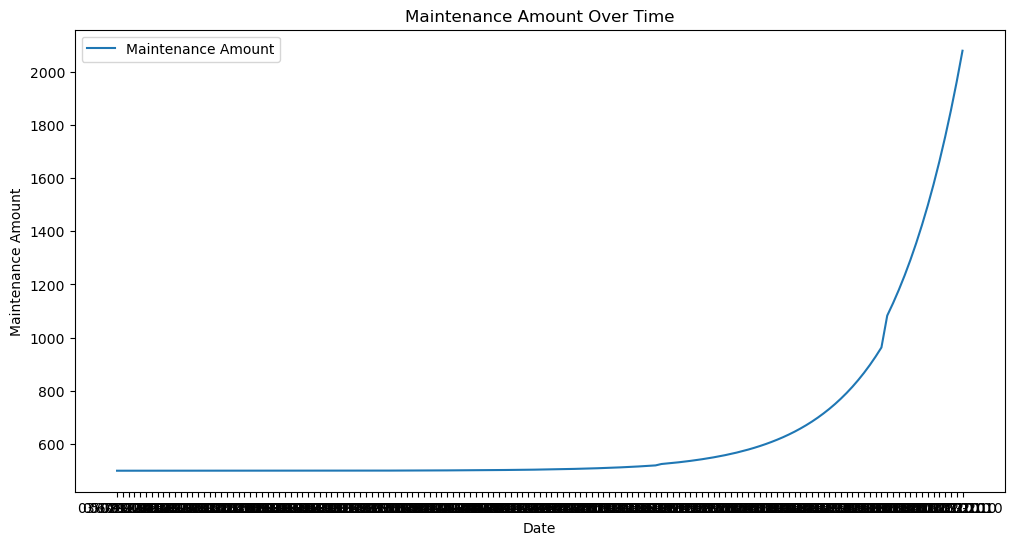

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(transport_data.index, transport_data['Maintenance Amount'], label='Maintenance Amount')
plt.title('Maintenance Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

#### Decompose time series

In [17]:
decomposition = seasonal_decompose(transport_data['Maintenance Amount'], model='additive', period=72)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

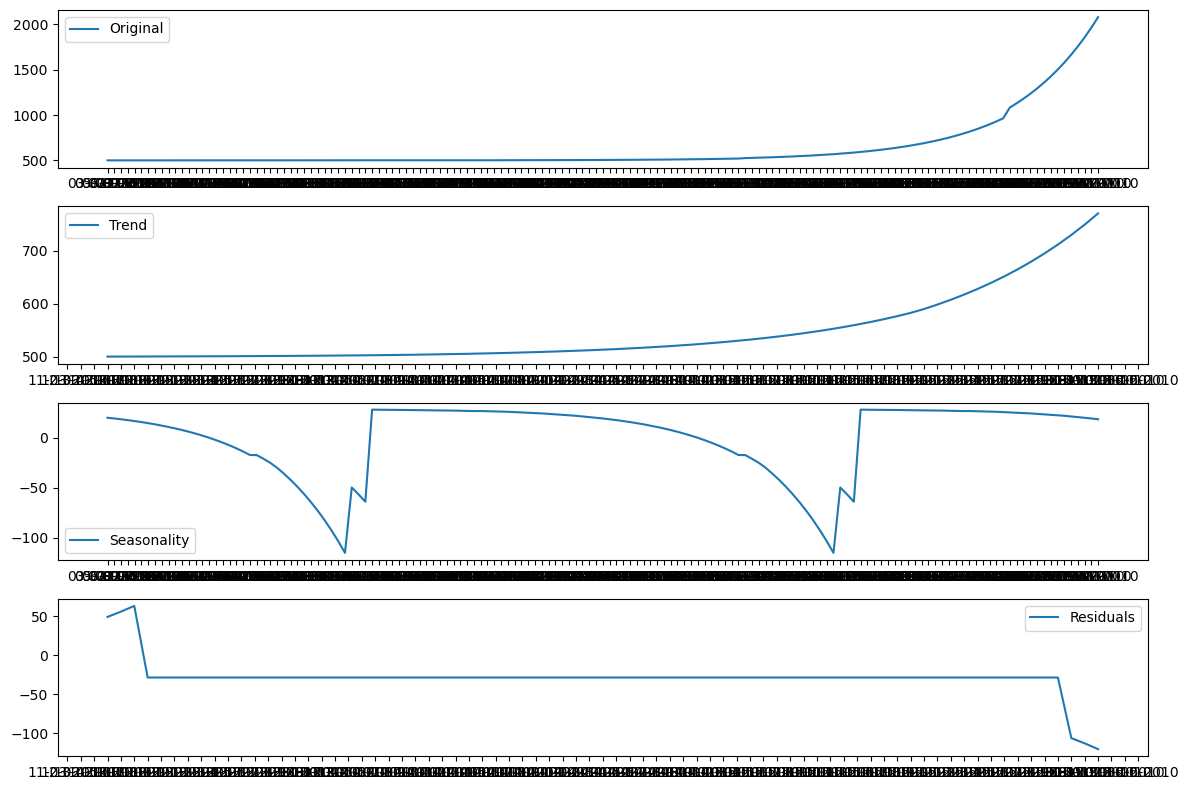

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(transport_data['Maintenance Amount'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Moving Avergae

In [19]:
transport_data['Maintenance Amount MA'] = transport_data['Maintenance Amount'].rolling(window=30).mean()

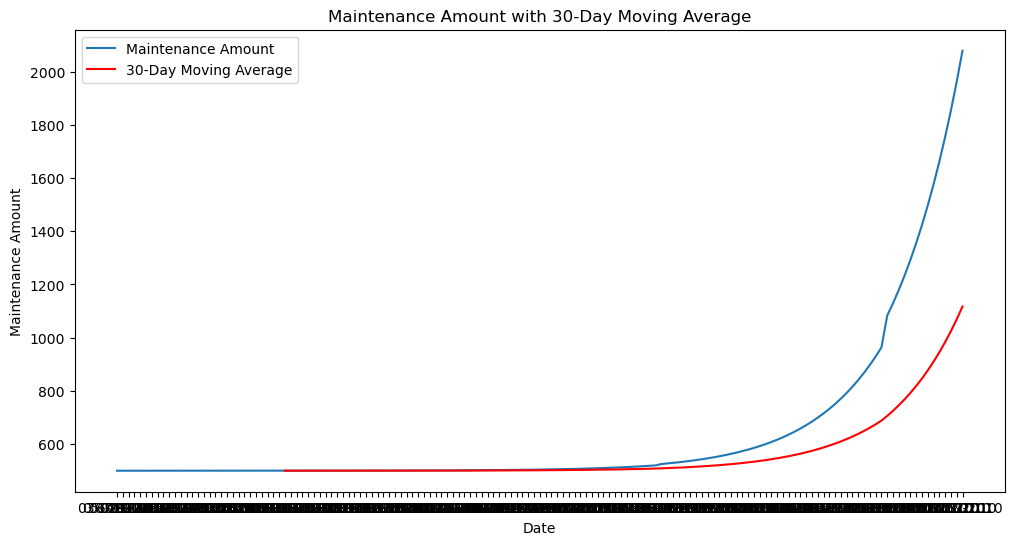

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(transport_data['Maintenance Amount'], label='Maintenance Amount')
plt.plot(transport_data['Maintenance Amount MA'], label='30-Day Moving Average', color='red')
plt.title('Maintenance Amount with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

#### Perform statistical tests for trends

In [21]:
tau, p_value = kendalltau(transport_data.dropna()['Maintenance Amount'].index.values, transport_data.dropna()['Maintenance Amount'].values)
print(f"Kendall's tau: {tau}, p-value: {p_value}")

Kendall's tau: 0.04823989569752282, p-value: 0.43861765981524803


#### Identify and analyze anomalies using rolling standard deviation

In [22]:
rolling_std = transport_data['Maintenance Amount'].rolling(window=30).std()
anomalies = transport_data[np.abs(transport_data['Maintenance Amount'] - transport_data['Maintenance Amount MA']) > 2 * rolling_std]

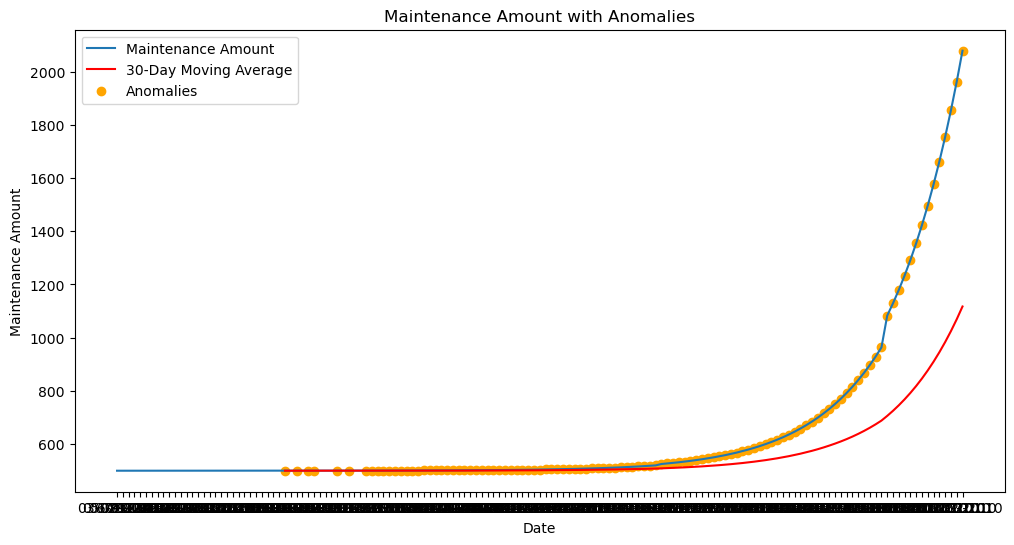

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(transport_data['Maintenance Amount'], label='Maintenance Amount')
plt.plot(transport_data['Maintenance Amount MA'], label='30-Day Moving Average', color='red')
plt.scatter(anomalies.index, anomalies['Maintenance Amount'], color='orange', label='Anomalies')
plt.title('Maintenance Amount with Anomalies')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

## Volatility Analysis

#### Calculate Daily change

In [24]:
transport_data['Average Fuel Level (%) Change'] = transport_data['Average Fuel Level (%)'].pct_change()
transport_data['Average Speed (km/h) Change'] = transport_data['Average Speed (km/h)'].pct_change()
transport_data['Total Engine Hours (h) Change'] = transport_data['Total Engine Hours (h)'].pct_change()

#### Calculate rolling standar deviation

In [25]:
std_dev = transport_data.std()
rolling_std_dev = transport_data.rolling(window=30).std()

#### Calculate annualized volatility

In [26]:
annualized_volatility = transport_data[['Average Fuel Level (%) Change', 'Average Speed (km/h) Change', 'Total Engine Hours (h) Change']].std() * np.sqrt(252)

#### Plot the rolling standard deviation for Maintenance Amount

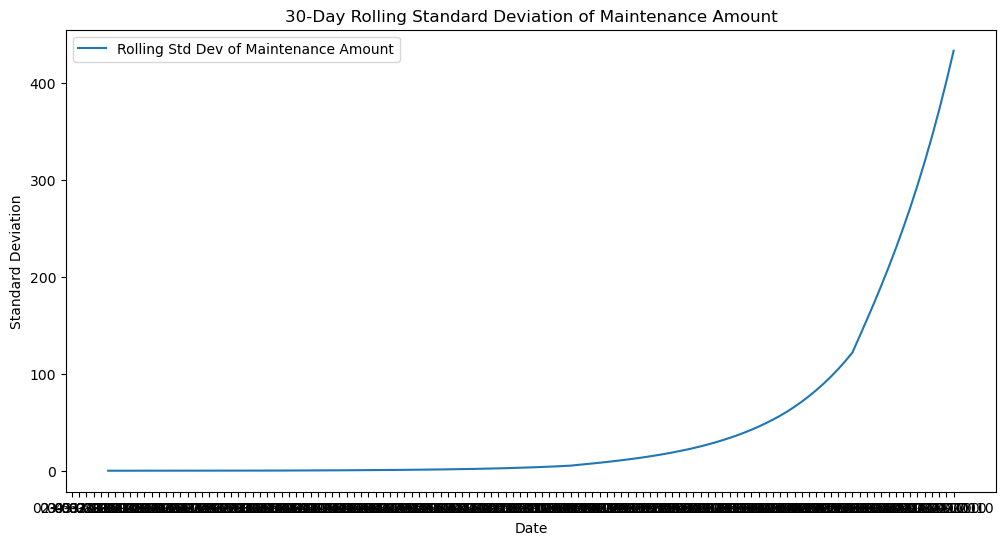

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_std_dev['Maintenance Amount'], label='Rolling Std Dev of Maintenance Amount')
plt.title('30-Day Rolling Standard Deviation of Maintenance Amount')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

#### Plot the rolling standard deviation

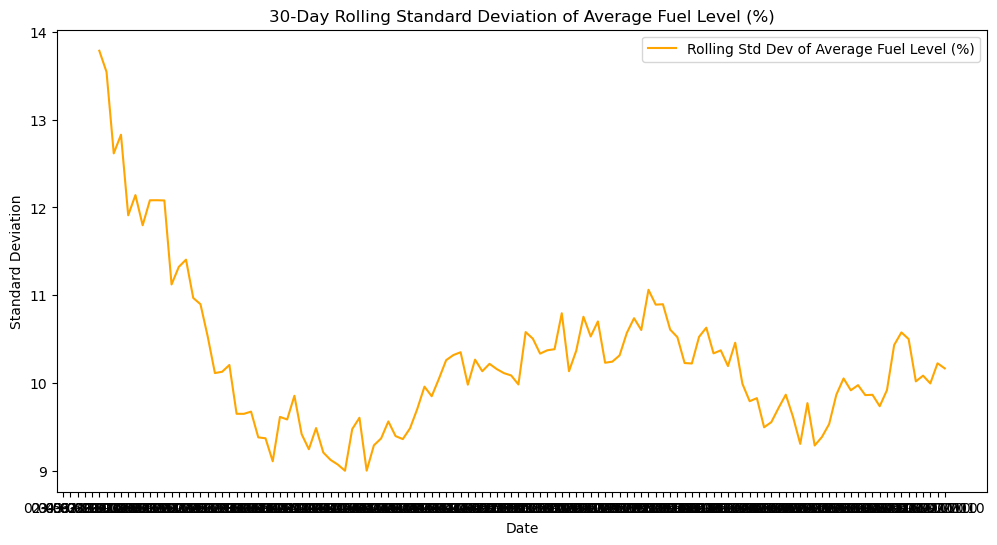

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_std_dev['Average Fuel Level (%)'], label='Rolling Std Dev of Average Fuel Level (%)', color='orange')
plt.title('30-Day Rolling Standard Deviation of Average Fuel Level (%)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

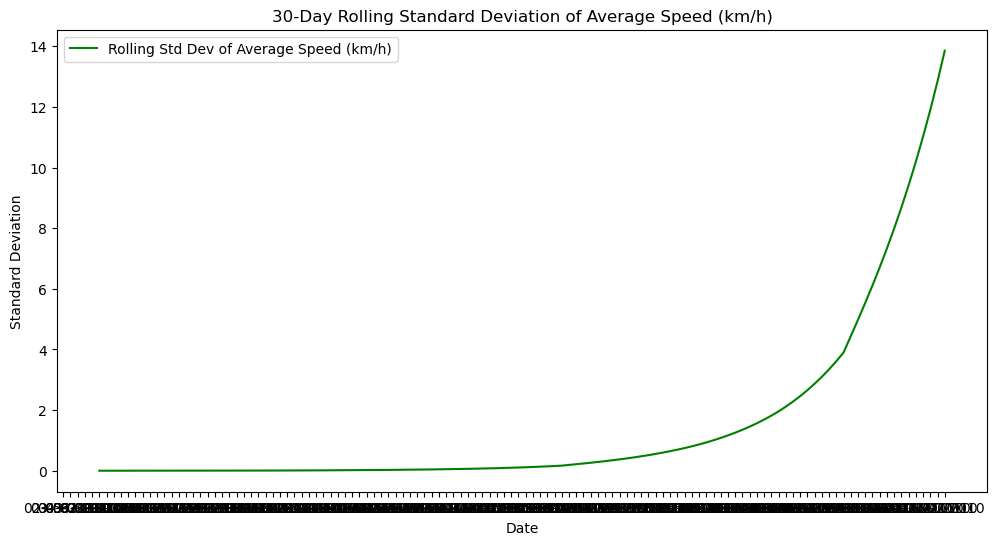

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_std_dev['Average Speed (km/h)'], label='Rolling Std Dev of Average Speed (km/h)', color='green')
plt.title('30-Day Rolling Standard Deviation of Average Speed (km/h)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

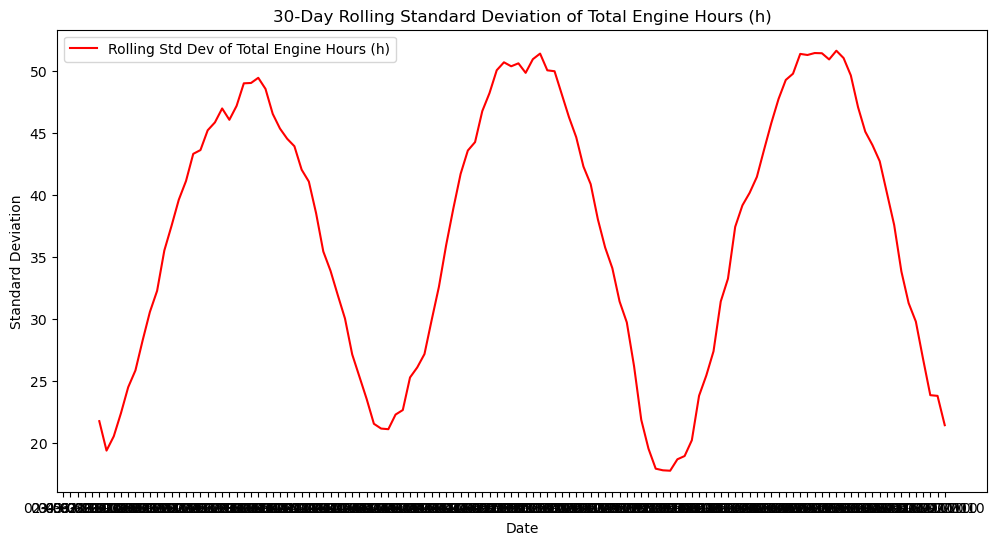

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_std_dev['Total Engine Hours (h)'], label='Rolling Std Dev of Total Engine Hours (h)', color='red')
plt.title('30-Day Rolling Standard Deviation of Total Engine Hours (h)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

#### Standard Deviation and Annualized Volatility

In [31]:
volatility_analysis = pd.DataFrame({
    'Standard Deviation': std_dev,
    'Annualized Volatility': annualized_volatility
})

volatility_analysis

,Standard Deviation,Annualized Volatility
Average Fuel Level (%),11.419095,NaN
Average Fuel Level (%) Change,0.235098,3.732066
Average Mileage (km),2.495901,NaN
Average Speed (km/h),9.975922,NaN
Average Speed (km/h) Change,0.011466,0.182010
Maintenance Amount,311.737870,NaN
Maintenance Amount MA,130.170611,NaN
Total Engine Hours (h),60.842529,NaN
Total Engine Hours (h) Change,0.069875,1.109226
Trip Distance (km),318.380954,NaN


# Diagnostic Analysis

## Correlation Analysis

#### Correlation Matrix

In [32]:
correlation_matrix = transport_data.corr()

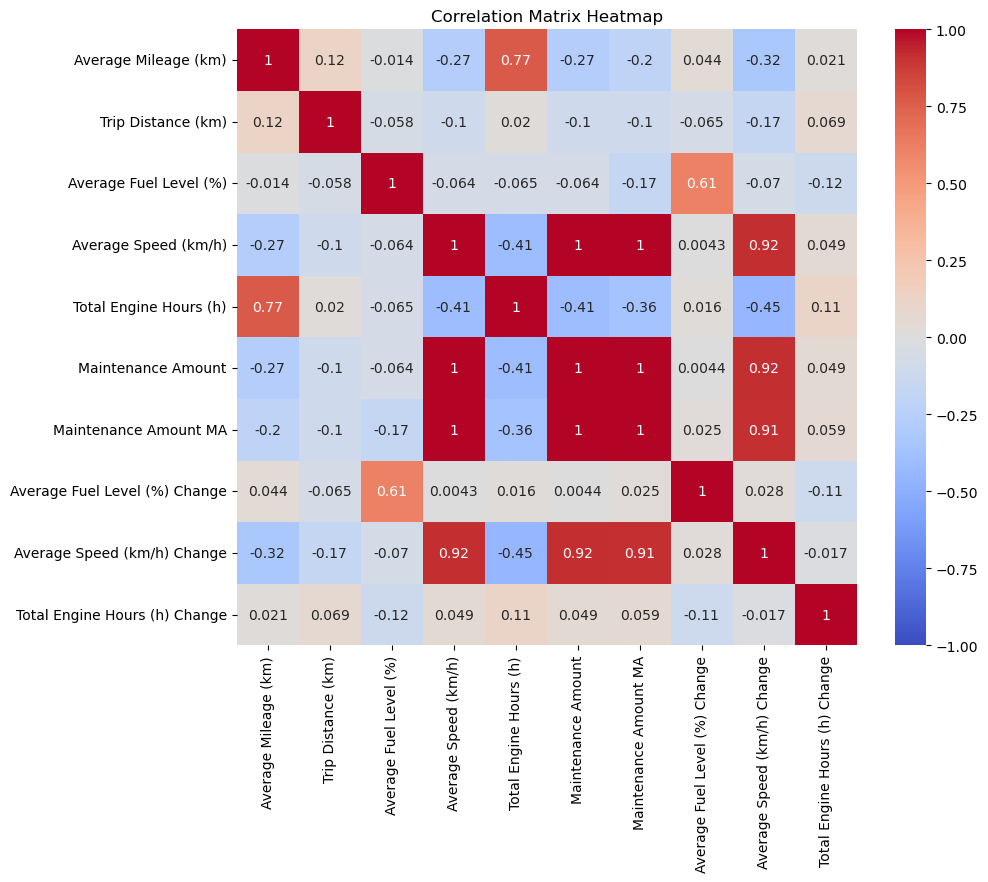

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Strong and weak correlations

In [34]:
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) | (correlation_matrix <= -0.7)]
weak_correlations = correlation_matrix[(correlation_matrix < 0.3) & (correlation_matrix > -0.3)]

In [35]:
print("Strong Correlations (|correlation| >= 0.7):")
print(strong_correlations)

Strong Correlations (|correlation| >= 0.7):
                               Average Mileage (km)  Trip Distance (km)  \
Average Mileage (km)                       1.000000                 NaN   
Trip Distance (km)                              NaN                 1.0   
Average Fuel Level (%)                          NaN                 NaN   
Average Speed (km/h)                            NaN                 NaN   
Total Engine Hours (h)                     0.767463                 NaN   
Maintenance Amount                              NaN                 NaN   
Maintenance Amount MA                           NaN                 NaN   
Average Fuel Level (%) Change                   NaN                 NaN   
Average Speed (km/h) Change                     NaN                 NaN   
Total Engine Hours (h) Change                   NaN                 NaN   

                               Average Fuel Level (%)  Average Speed (km/h)  \
Average Mileage (km)                              N

In [36]:
print("\nWeak Correlations (|correlation| < 0.3):")
print(weak_correlations)


Weak Correlations (|correlation| < 0.3):
                               Average Mileage (km)  Trip Distance (km)  \
Average Mileage (km)                            NaN            0.120306   
Trip Distance (km)                         0.120306                 NaN   
Average Fuel Level (%)                    -0.013865           -0.058373   
Average Speed (km/h)                      -0.270276           -0.103299   
Total Engine Hours (h)                          NaN            0.020271   
Maintenance Amount                        -0.270249           -0.103297   
Maintenance Amount MA                     -0.204106           -0.102371   
Average Fuel Level (%) Change              0.044439           -0.065187   
Average Speed (km/h) Change                     NaN           -0.171852   
Total Engine Hours (h) Change              0.020908            0.068522   

                               Average Fuel Level (%)  Average Speed (km/h)  \
Average Mileage (km)                        -0.013865

In [37]:
correlation_matrix

,Average Mileage (km),Trip Distance (km),Average Fuel Level (%),Average Speed (km/h),Total Engine Hours (h),Maintenance Amount,Maintenance Amount MA,Average Fuel Level (%) Change,Average Speed (km/h) Change,Total Engine Hours (h) Change
Average Mileage (km),1.000000,0.120306,-0.013865,-0.270276,0.767463,-0.270249,-0.204106,0.044439,-0.320716,0.020908
Trip Distance (km),0.120306,1.000000,-0.058373,-0.103299,0.020271,-0.103297,-0.102371,-0.065187,-0.171852,0.068522
Average Fuel Level (%),-0.013865,-0.058373,1.000000,-0.063577,-0.065282,-0.063571,-0.169431,0.610914,-0.070445,-0.123257
Average Speed (km/h),-0.270276,-0.103299,-0.063577,1.000000,-0.412604,1.000000,0.999438,0.004346,0.918168,0.048571
Total Engine Hours (h),0.767463,0.020271,-0.065282,-0.412604,1.000000,-0.412586,-0.363239,0.015836,-0.451061,0.113755
Maintenance Amount,-0.270249,-0.103297,-0.063571,1.000000,-0.412586,1.000000,0.999438,0.004353,0.918164,0.048573
Maintenance Amount MA,-0.204106,-0.102371,-0.169431,0.999438,-0.363239,0.999438,1.000000,0.024564,0.908461,0.059031
Average Fuel Level (%) Change,0.044439,-0.065187,0.610914,0.004346,0.015836,0.004353,0.024564,1.000000,0.027981,-0.111501
Average Speed (km/h) Change,-0.320716,-0.171852,-0.070445,0.918168,-0.451061,0.918164,0.908461,0.027981,1.000000,-0.017289
Total Engine Hours (h) Change,0.020908,0.068522,-0.123257,0.048571,0.113755,0.048573,0.059031,-0.111501,-0.017289,1.000000


## Anamoly Detection

#### Isolation Forest Model

In [38]:
features = ['Maintenance Amount', 'Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 'Total Engine Hours (h)', 'Trip Distance (km)']
X = transport_data[features]

In [39]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
transport_data['Anomaly'] = iso_forest.fit_predict(X)

In [40]:
anomalies = transport_data[transport_data['Anomaly'] == -1]

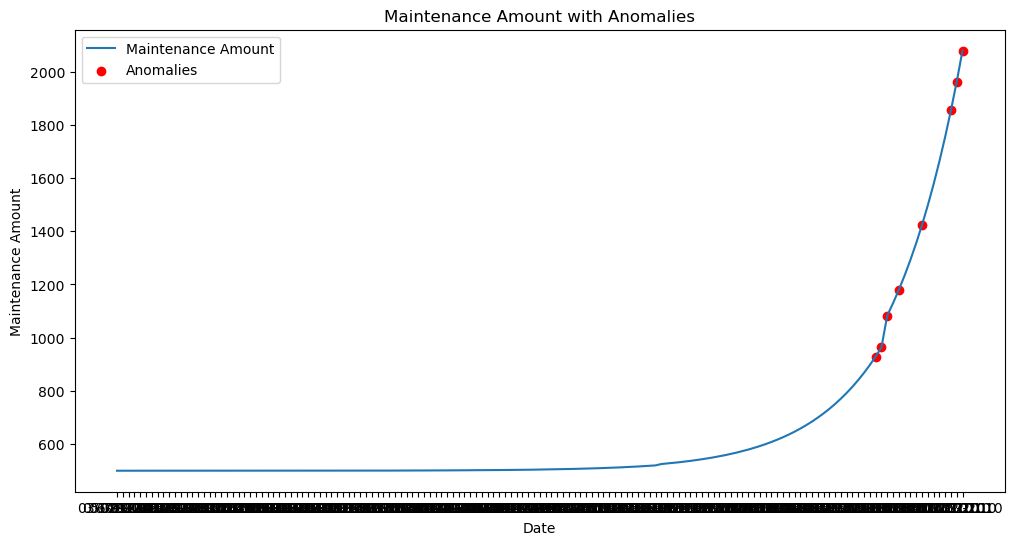

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(transport_data.index, transport_data['Maintenance Amount'], label='Maintenance Amount')
plt.scatter(anomalies.index, anomalies['Maintenance Amount'], color='red', label='Anomalies')
plt.title('Maintenance Amount with Anomalies')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

In [42]:
anomalies

,Average Mileage (km),Trip Distance (km),Average Fuel Level (%),Average Speed (km/h),Total Engine Hours (h),Maintenance Amount,Maintenance Amount MA,Average Fuel Level (%) Change,Average Speed (km/h) Change,Total Engine Hours (h) Change,Anomaly
Date,,,,,,,,,,,
21-06-2010,15.0,6534.850171,85.673049,53.730717,154.113587,929.123582,674.436745,0.462786,0.019210,-0.088969,-1
22-06-2010,15.0,6970.067889,56.350661,54.824167,175.434086,963.253128,688.328135,-0.342259,0.020351,0.138343,-1
25-06-2010,12.0,5031.289467,69.677628,58.655472,153.623785,1082.968613,706.086454,0.236501,0.069884,-0.124322,-1
27-06-2010,11.0,5527.547286,59.820559,61.745426,151.477976,1179.564964,745.962428,-0.004908,0.026673,-0.134958,-1
01-07-2010,14.0,5817.694842,89.314498,69.544478,180.252928,1423.266998,846.616734,0.488536,0.032346,0.025137,-1
06-07-2010,15.0,5919.900433,65.940326,83.337872,193.668529,1854.296009,1024.622787,-0.197130,0.039889,0.067425,-1
07-07-2010,16.0,5943.101822,55.926229,86.789306,219.459350,1962.187342,1069.165594,-0.151866,0.041415,0.133170,-1
08-07-2010,15.0,5936.609901,71.525429,90.515429,197.022537,2078.568591,1117.252733,0.278925,0.042933,-0.102237,-1


# Predicton Models - Regression

## XG Boost

#### Feature Engineering

In [43]:
for lag in range(1, 11):
    transport_data[f'Lag_{lag}'] = transport_data['Maintenance Amount'].shift(lag)
    
transport_data.dropna(inplace=True)
features = [f'Lag_{lag}' for lag in range(1, 11)] + ['Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 'Total Engine Hours (h)', 'Trip Distance (km)']
target = 'Maintenance Amount'

In [44]:
X = transport_data[features]
y = transport_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=None, test_size=0.2, random_state=42)

#### Train

In [45]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Predict

In [46]:
y_pred = model.predict(X_test)
next_10_days = model.predict(X.tail(10))

In [47]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 32.07925954888131


#### Review

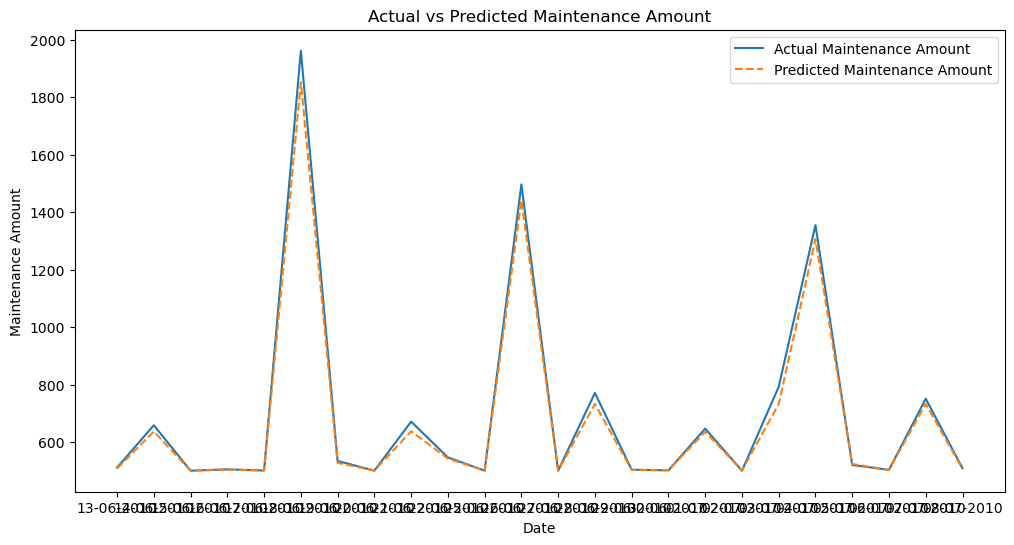

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(transport_data.index[-len(y_test):], y_test, label='Actual Maintenance Amount')
plt.plot(transport_data.index[-len(y_test):], y_pred, label='Predicted Maintenance Amount', linestyle='dashed')
plt.title('Actual vs Predicted Maintenance Amount')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

In [49]:
next_10_days_df = pd.DataFrame({
    'Date': pd.date_range(start=pd.Timestamp(transport_data.index[-1]) + pd.Timedelta(days=1), periods=10, freq='D'),
    'Predicted Maintenance Amount': next_10_days
})

next_10_days_df

,Date,Predicted Maintenance Amount
0,2010-08-08,1292.078979
1,2010-08-09,1306.307617
2,2010-08-10,1423.265991
3,2010-08-11,1442.322510
4,2010-08-12,1576.172852
5,2010-08-13,1661.884888
6,2010-08-14,1754.377197
7,2010-08-15,1854.297485
8,2010-08-16,1852.205200
9,2010-08-17,2078.567871


#### Feature Importance

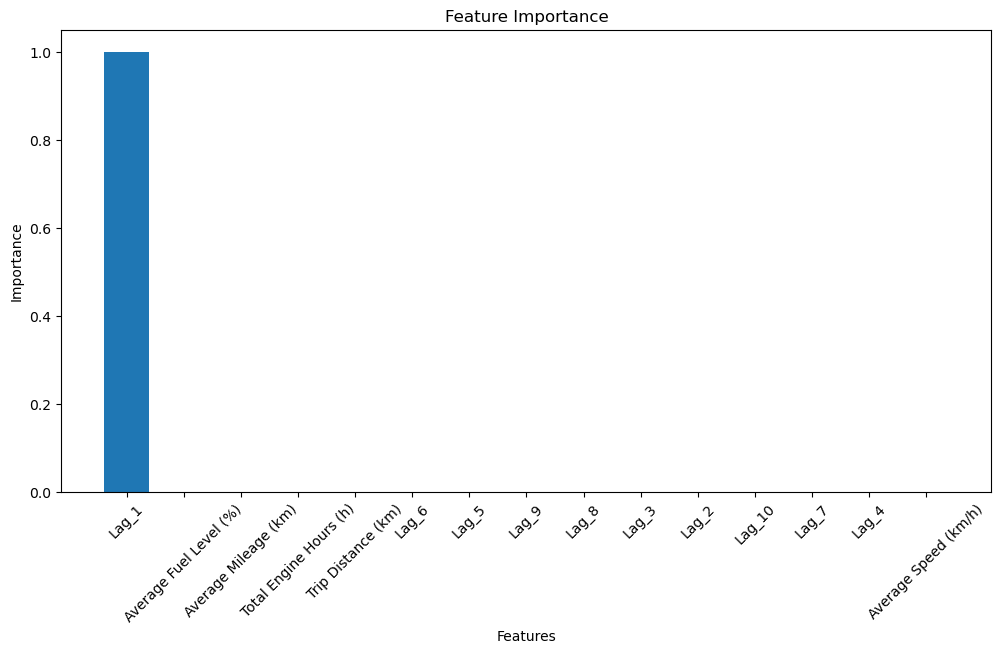

In [50]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

### Hyperparameter Tuning 1

In [51]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}


In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [54]:
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}


In [55]:
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
y_pred = best_xgb.predict(X_test_scaled)

In [57]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 30.364405806351776


In [58]:
feature_importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

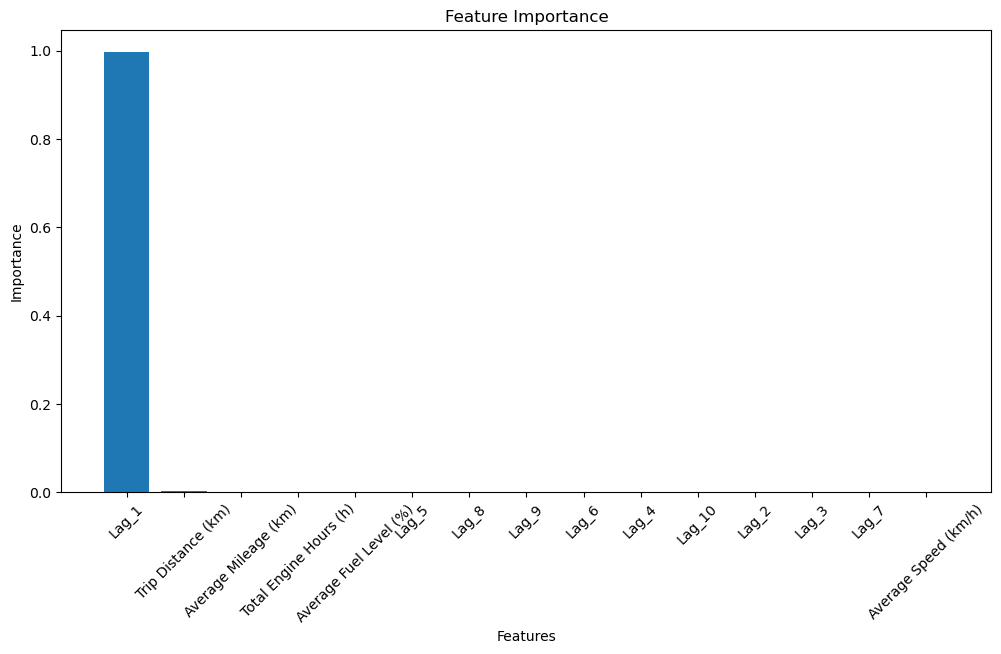

In [59]:
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

### Recursive Forecasting of next unknown 10 days.

#### Feature Generation LSTM

In [60]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
transport_data_scaled = scaler.fit_transform(transport_data)

def create_lstm_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

time_steps = 10
X_lstm, y_lstm = create_lstm_dataset(transport_data_scaled, time_steps)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, transport_data_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(transport_data_scaled.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

last_10_days = transport_data_scaled[-time_steps:]
future_features = []

for _ in range(10):
    X_input = last_10_days.reshape((1, time_steps, transport_data_scaled.shape[1]))
    next_feature = model.predict(X_input)
    future_features.append(next_feature[0])
    last_10_days = np.append(last_10_days[1:], next_feature, axis=0)

future_features = scaler.inverse_transform(future_features)
future_features_df = pd.DataFrame(future_features, columns=transport_data.columns)
future_features_df.index = pd.date_range(start=pd.Timestamp(transport_data.index[-1]) + pd.Timedelta(days=1), periods=10, freq='B')





Epoch 1/50

3/3 [==============================] - 4s 411ms/step - loss: 0.1602 - val_loss: 0.1122
Epoch 2/50
3/3 [==============================] - 0s 28ms/step - loss: 0.1279 - val_loss: 0.0826
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0973 - val_loss: 0.0591
Epoch 4/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0782 - val_loss: 0.0457
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0667 - val_loss: 0.0396
Epoch 6/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0640 - val_loss: 0.0349
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0576 - val_loss: 0.0307
Epoch 8/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0521 - val_loss: 0.0271
Epoch 9/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0449 - val_loss: 0.0241
Epoch 10/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0404 - val_loss: 0.0222
Epoch 11/50
3/3 [=======

### Predict using XGBoost

In [61]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

features = [f'Lag_{lag}' for lag in range(1, 11)] + ['Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 'Total Engine Hours (h)', 'Trip Distance (km)']
target = 'Maintenance Amount'

X_predict = future_features_df[features]
y_predict = future_features_df[target]

scaler_xgb = StandardScaler()
X_predicts_scaled = scaler_xgb.fit_transform(X_predict)

y_pred = best_xgb.predict(X_predicts_scaled)
mse = mean_squared_error(y_predict, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

next_10_days_df = future_features_df[['Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 'Total Engine Hours (h)', 'Trip Distance (km)']].copy()
next_10_days_df['Predicted Maintenance Amount'] = y_pred 

next_10_days_df


Root Mean Squared Error: 1317.1022863176868


,Average Mileage (km),Average Fuel Level (%),Average Speed (km/h),Total Engine Hours (h),Trip Distance (km),Predicted Maintenance Amount
2010-08-09,15.333740,75.565450,90.879933,209.076094,5785.742991,504.779419
2010-08-10,15.518528,76.034613,92.301819,213.374997,5772.133967,501.232269
2010-08-11,15.642528,76.457895,93.627236,216.342319,5762.349117,501.037445
2010-08-12,15.784164,76.823308,94.689327,218.699842,5768.855347,548.318054
2010-08-13,15.877806,77.183624,95.592964,220.918628,5761.843457,702.552979
2010-08-16,16.025259,77.615553,96.311289,223.954705,5760.859595,754.551331
2010-08-17,16.079961,77.821876,96.877139,225.054301,5753.739796,876.928223
2010-08-18,16.171066,78.114929,97.323246,226.675059,5751.750561,932.923645
2010-08-19,16.204420,78.270392,97.763945,226.899484,5756.052819,1162.618408
2010-08-20,16.216200,78.357043,98.137072,226.714019,5759.533799,1162.840698


In [62]:
transport_data[['Maintenance Amount']].tail(10)

,Maintenance Amount
Date,
29-06-2010,1292.078169
30-06-2010,1355.158476
01-07-2010,1423.266998
02-07-2010,1496.790040
03-07-2010,1576.172971
04-07-2010,1661.884982
05-07-2010,1754.376624
06-07-2010,1854.296009
07-07-2010,1962.187342


### Other models

Linear Regression - RMSE: 0.07705970557183905
Random Forest - RMSE: 21.057157611138066
SVR - RMSE: 406.5329663494755
MLP Regressor - RMSE: 744.1245583774066


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


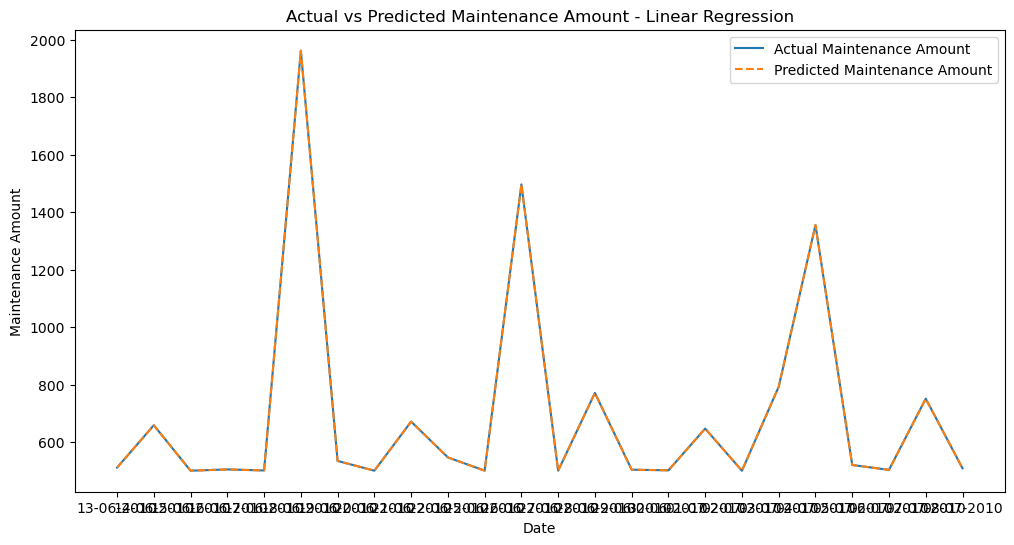

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Date,Predicted Maintenance Amount
0,2010-08-09,22278.141680
1,2010-08-10,22969.361744
2,2010-08-11,23670.706882
3,2010-08-12,24516.282982
4,2010-08-13,25298.778048
5,2010-08-16,26208.945634
6,2010-08-17,27186.970167
7,2010-08-18,28246.870229
8,2010-08-19,29391.197322
9,2010-08-20,30626.791055


In [64]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[model_name] = {'RMSE': rmse, 'Model': model}
    print(f'{model_name} - RMSE: {rmse}')

best_model_name = min(results, key=lambda k: results[k]['RMSE'])
best_model = results[best_model_name]['Model']
y_pred_best = best_model.predict(X_test_scaled)

plt.figure(figsize=(12, 6))
plt.plot(transport_data.index[-len(y_test):], y_test, label='Actual Maintenance Amount')
plt.plot(transport_data.index[-len(y_test):], y_pred_best, label='Predicted Maintenance Amount', linestyle='dashed')
plt.title(f'Actual vs Predicted Maintenance Amount - {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Maintenance Amount')
plt.legend()
plt.show()

next_10_days = best_model.predict(X.tail(10))

next_10_days_df = pd.DataFrame({
    'Date': pd.date_range(start=pd.Timestamp(transport_data.index[-1]) + pd.Timedelta(days=1), periods=10, freq='B'),
    'Predicted Maintenance Amount': next_10_days
})

next_10_days_df


In [65]:
transport_data.head(5)

,Average Mileage (km),Trip Distance (km),Average Fuel Level (%),Average Speed (km/h),Total Engine Hours (h),Maintenance Amount,Maintenance Amount MA,Average Fuel Level (%) Change,Average Speed (km/h) Change,Total Engine Hours (h) Change,...,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10
Date,,,,,,,,,,,,,,,,,,,,,
07-03-2010,18.0,5986.674859,78.328835,40.003659,284.867343,500.158129,500.065367,-0.078990,0.000007,0.016708,...,500.166195,500.088869,500.116666,500.078808,500.124178,500.038468,500.135151,500.088703,500.074968,500.083679
08-03-2010,15.0,5986.027750,58.024614,40.004037,283.924380,500.150880,500.069496,-0.259218,0.000009,-0.003310,...,500.158129,500.166195,500.088869,500.116666,500.078808,500.124178,500.038468,500.135151,500.088703,500.074968
09-03-2010,19.0,5967.107793,85.909864,40.004354,258.284860,500.191776,500.074947,0.480576,0.000008,-0.090304,...,500.150880,500.158129,500.166195,500.088869,500.116666,500.078808,500.124178,500.038468,500.135151,500.088703
10-03-2010,16.0,6010.760018,82.323550,40.004626,256.667580,500.162918,500.079253,-0.041745,0.000007,-0.006262,...,500.191776,500.150880,500.158129,500.166195,500.088869,500.116666,500.078808,500.124178,500.038468,500.135151
11-03-2010,18.0,5996.466993,66.177471,40.004986,253.056430,500.205202,500.084459,-0.196130,0.000009,-0.014069,...,500.162918,500.191776,500.150880,500.158129,500.166195,500.088869,500.116666,500.078808,500.124178,500.038468


# Scenario Generation

#### Define abnormal scenarios

In [66]:
scenarios = {
    'Scenario 1': {
        'Average Mileage (km)': transport_data['Average Mileage (km)'] * 0.8,  # 20% decrease
        'Average Fuel Level (%)': transport_data['Average Fuel Level (%)'] * 0.9,  # 10% decrease
        'Average Speed (km/h)': transport_data['Average Speed (km/h)'] * 0.9,  # 10% decrease
        'Total Engine Hours (h)': transport_data['Total Engine Hours (h)'] * 0.9,  # 10% decrease
        'Trip Distance (km)': transport_data['Trip Distance (km)'] * 1.2  # 20% increase
    },
    'Scenario 2': {
        'Average Mileage (km)': transport_data['Average Mileage (km)'] * 1.2,  # 20% increase
        'Average Fuel Level (%)': transport_data['Average Fuel Level (%)'] * 1.1,  # 10% increase
        'Average Speed (km/h)': transport_data['Average Speed (km/h)'] * 1.1,  # 10% increase
        'Total Engine Hours (h)': transport_data['Total Engine Hours (h)'] * 1.1,  # 10% increase
        'Trip Distance (km)': transport_data['Trip Distance (km)'] * 0.8  # 20% decrease
    }
}


#### Train a model

In [67]:
X = transport_data[['Average Mileage (km)', 'Average Fuel Level (%)', 'Average Speed (km/h)', 'Total Engine Hours (h)', 'Trip Distance (km)']]
y = transport_data['Maintenance Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Predict scenario

In [68]:
predictions = {}
for scenario_name, scenario_data in scenarios.items():
    scenario_df = pd.DataFrame(scenario_data)
    scenario_predictions = model.predict(scenario_df)
    predictions[scenario_name] = scenario_predictions

In [69]:
transport_data.shape

(118, 21)

In [70]:
predictions_df = pd.DataFrame(predictions, index=transport_data.index)

In [71]:
predictions_df.head()

,Scenario 1,Scenario 2
Date,,
07-03-2010,375.125055,625.166114
08-03-2010,375.118891,625.155574
09-03-2010,375.151180,625.199106
10-03-2010,375.147229,625.191137
11-03-2010,375.159860,625.208623
